In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, date
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost.sklearn import XGBClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split,StratifiedShuffleSplit,StratifiedKFold
from sklearn.metrics import recall_score,f1_score,roc_auc_score,accuracy_score,confusion_matrix
from sklearn.model_selection import StratifiedShuffleSplit


In [2]:
train_data = pd.read_csv('../../../data/feature/user_feature_train_2.csv')
#test_data = pd.read_csv('../../data/test_data1.csv')
train_data.head()

,user_id,merchant_id,user_viewed_action_count,user_viewed_item_cat_num,user_viewed_item_brand_num,user_viewed_item_num,user_viewed_item_click,user_viewed_item_addcart,user_viewed_item_buy,user_viewed_item_addcat,...,user_click_ratio,user_buy_ratio,user_addcat_ratio,user_buy_ratio2,repeat_viewed_count,repeat_buyer_same_item_count,repeat_buyer_diff_item_count,age_range,gender,label
0,34176,3906,39,6,1,20,36,0,1,2,...,0.923077,0.025641,0.051282,0.333333,2,0,1,6.0,0.0,0
1,34176,121,14,1,1,1,13,0,1,0,...,0.928571,0.071429,0.000000,1.000000,1,0,1,6.0,0.0,0
2,34176,4356,18,1,1,2,12,0,6,0,...,0.666667,0.333333,0.000000,1.000000,1,1,2,6.0,0.0,1
3,34176,2217,2,1,1,1,1,0,1,0,...,0.500000,0.500000,0.000000,1.000000,0,0,1,6.0,0.0,0
4,230784,4818,8,1,1,1,7,0,1,0,...,0.875000,0.125000,0.000000,1.000000,1,0,1,0.0,0.0,0


In [21]:
y = train_data['label'].values
X = train_data.drop(['label', 'user_id', 'merchant_id'], axis=1).values
X.shape

(260864, 18)

#### 切下数据,交叉验证一下,然后简单跑一次看看

In [22]:
ss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=2018)
for train_index ,test_index in ss.split(X, y):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

TRAIN: [133396  70415 205049 ..., 240081 238195 240749] TEST: [109297 175700 133527 ..., 118224 196859   9818]


In [23]:
#样本权重
def get_scale_pos_weight(y_train):
    label = y_train.value_counts()
    ratio = float(label[0]) / float(label[1])
    return ratio
class_weight = get_scale_pos_weight(train_data['label'])

In [24]:
lr = LogisticRegression(C=0.01, penalty='l2', class_weight='balanced', random_state=2018)

lr.fit(X_train, y_train)

preds = lr.predict(X_test)

# 判断准确率
print ('错误类为%f' %((preds!=y_test).sum()/float(y_test.shape[0])))
print("recall_score : %.3f" % recall_score(preds, y_test))
print("f1_score : %.3f" %  f1_score(preds, y_test))
print("auc : %.3f" % roc_auc_score(preds, y_test))
print("accuracy_score : %.3f " % accuracy_score(preds, y_test))
print ("混淆矩阵：",confusion_matrix(y_test, preds))

错误类为0.271020
recall_score : 0.100
f1_score : 0.162
auc : 0.526
accuracy_score : 0.729 
混淆矩阵： [[54999 18475]
 [ 2735  2051]]


In [88]:
y_test

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [9]:
print(train_data.drop(['label', 'user_id', 'merchant_id', 'age_range', 'gender'], axis=1).columns)
print(lr.coef_)

Index(['user_viewed_action_count', 'user_viewed_item_cat_num',
       'user_viewed_item_brand_num', 'user_viewed_item_num',
       'user_viewed_item_click', 'user_viewed_item_addcart',
       'user_viewed_item_buy', 'user_viewed_item_addcat', 'user_addcart_ratio',
       'user_click_ratio', 'user_buy_ratio', 'user_addcat_ratio',
       'user_buy_ratio2', 'repeat_viewed_count',
       'repeat_buyer_same_item_count', 'repeat_buyer_diff_item_count'],
      dtype='object')
[[-0.01759931  0.08074763 -0.02768851  0.01521044  0.01788091 -0.16819
   0.11607277  0.01663701  0.53376493 -0.45092877 -0.46263126  0.23879636
   0.06554797  0.00257542  0.18582948  0.09498844]]


In [25]:
cv_lr = LogisticRegression(penalty='l2', class_weight='balanced', random_state=2018)
param_grid = {'C': [0.001, 0.01, 0.1, 1]}
grid_search = GridSearchCV(cv_lr, param_grid, cv=ss, scoring='roc_auc')
grid_search.fit(X_train, y_train)
grid_search.score(X_test, y_test)


0.61539940853794328

In [27]:
print(grid_search.best_params_)
print(grid_search.best_score_)
print(grid_search.best_estimator_)
grid_search.grid_scores_

{'C': 0.001}
0.622153331569
LogisticRegression(C=0.001, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=2018,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)


C:\Users\zzf\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.62215, std: 0.00000, params: {'C': 0.001},
 mean: 0.62161, std: 0.00000, params: {'C': 0.01},
 mean: 0.62158, std: 0.00000, params: {'C': 0.1},
 mean: 0.62165, std: 0.00000, params: {'C': 1}]

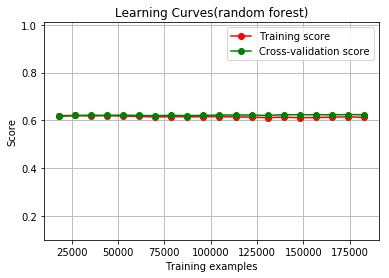

In [20]:
from sklearn.model_selection import learning_curve
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 20), scoring='roc_auc'):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring=scoring)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

title = 'Learning Curves(random forest)'
plot_learning_curve(lr, title, X, y, (0.1, 1.01), cv=ss, n_jobs=4)
plt.show()